In [1]:
!rm -rf sample_data
%tensorflow_version 1.x
import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
from IPython.display import clear_output
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

%matplotlib inline

TensorFlow 1.x selected.


In [2]:
uploaded = list(files.upload().keys())

if len(uploaded) > 1:
  raise ValueError('You cannot upload more than one audio at a time!')

cont = uploaded[0]
CONTENT_FILENAME = "content." + cont.split(".")[-1]
os.rename(cont, CONTENT_FILENAME)
content_sec = int(librosa.get_duration(filename=CONTENT_FILENAME))
clear_output()

print("Content: ")
display(Audio(CONTENT_FILENAME))

Content: 


In [3]:
uploaded = list(files.upload().keys())

if len(uploaded) > 1:
  raise ValueError('You cannot upload more than one audio at a time!')

sty = uploaded[0]
STYLE_FILENAME = "style." + sty.split(".")[-1]
os.rename(sty, STYLE_FILENAME)
clear_output()

print("Style: ")
display(Audio(STYLE_FILENAME))

Style: 


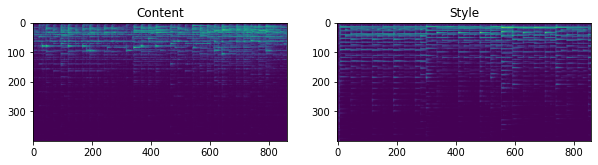

In [7]:
N_FFT = 2048
CS = content_sec*43
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:CS]))  
    return S, fs

a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]

N_FILTERS = 4096

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
    
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES
clear_output()

# Visualize spectrograms for content and style tracks
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

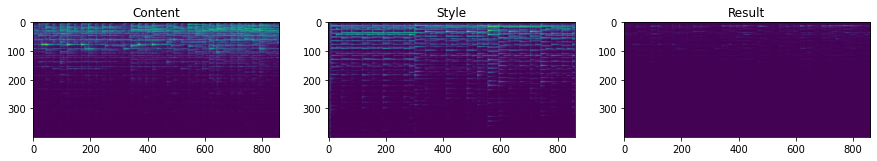

In [11]:
from sys import stderr


ALPHA= 1e-2
learning_rate= 0.001 
iterations = 2000 

result = None
with tf.Graph().as_default():

    # Build graph with variable input
    #x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    
    net = tf.nn.relu(conv)

    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 500})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print(f'Final loss: {loss.eval()}')
        result = x.eval()

a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'mix_sad_result.wav'
# librosa.output.write_wav(OUTPUT_FILENAME, x, fs)
sf.write(OUTPUT_FILENAME, x, fs)
clear_output()

# Visualize spectrograms
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()